In [1]:
import os
import sys
sys.path.insert(0, "/home/joonyoung/Python/COBRAme/ME-models/me/Scripts")

from pandas import DataFrame, Panel, ExcelWriter
import pandas
from scipy.stats import hypergeom
import glob
from cPickle import load
import math
import pickle
import json

In [11]:
simulation_directory = "/home/joonyoung/Python/COBRAme/90_COBRAme_simulations/"
files = glob.glob( simulation_directory + "*_transcription.json" )
n_source_list = []

dic_expression = {}
for path in files:
    split_0 = path.split("/")
    split_1 = split_0[6].split("_e")
    n_source = split_1[0]
    n_source_list.append(n_source)
    
    with open( path ) as json_file:
        json_data = json.load(json_file)
        expression = pandas.DataFrame( json_data, index = [ 0 ] )
        expression = expression.transpose()
        expression.columns = [ n_source ]
        dic_expression[ n_source ] = expression
        print "Loaded... " + path

Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/acnam_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/udpg_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/amp_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/dad__2_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/uacgam_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/cytd_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/imp_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/pser__L_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/gua_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/ump_e_COBRAme_transcription.json
Loaded... /home/

Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/xan_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/acmum_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/uri_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/alaala_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/23cgmp_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/no3_e_COBRAme_transcription.json
Loaded... /home/joonyoung/Python/COBRAme/90_COBRAme_simulations/acmana_e_COBRAme_transcription.json


In [12]:
df_expr = dic_expression[ "nh4" ].copy()
print df_expr.shape

for nsource in n_source_list:
    if nsource == "nh4" :
        continue
    df_expr = df_expr.merge( dic_expression[ nsource ], left_index = True, right_index = True )

# round down numerical error to 1e-15 (nonzero so log will be define)
df_expr[ df_expr < 1e-10 ] = 1e-15
df_expr_scaled = df_expr.apply( lambda x: x / x.sum() )  # all positive values

(1679, 1)


In [13]:
import math
df_diff = df_expr_scaled.copy()
for i in df_expr_scaled.columns:
    #df_diff[ i ] = ( log( df_expr_scaled[ i ] ) - log( df_expr_scaled[ "nh4" ] ) ) / log( 2.0 )
    df_temp = df_expr_scaled[ i ].div( df_expr_scaled[ "nh4" ] )
    df_diff[ i ] = df_temp.apply( lambda x: math.log( x ) ) / math.log( 2.0 )
df_diff_all = df_diff.copy()
df_diff[ df_diff.abs() < 1 ] = 0

In [14]:
# we will call a gene differentially expressed if in ME it changes by 2-fold at least
changed_unfiltered = df_diff.abs() > 1

In [15]:
reg2 = load( open( "/home/joonyoung/Python/COBRAme/hypergeom_tables/reg3.pickle", "rb" ) )
regulation_unfiltered = pandas.read_pickle( "/home/joonyoung/Python/COBRAme/hypergeom_tables/regulation_unfiltered_2.pickle" )

bnums_in_regulondb = DataFrame( reg2 ).index
genes_in_simulation = df_expr.index
print "genes which can be regulated in regulondb", len( bnums_in_regulondb )
print "genes which can be simulated", len( genes_in_simulation )
genes_both = bnums_in_regulondb.intersection( genes_in_simulation )
n_genes_both = len( genes_both )
print "genes which can be simulated and in regulon db", n_genes_both

genes which can be regulated in regulondb 1620
genes which can be simulated 1679
genes which can be simulated and in regulon db 942


In [16]:
# filter to only genes in both simulation and regulondb
changed = changed_unfiltered.loc[genes_both]
# remove TFs for which do not regulate anything in the model also
regulation = regulation_unfiltered.loc[genes_both].dropna( axis = 1 , how = "all")
regulation.shape

/home/joonyoung/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


(942, 156)

In [17]:
# sum how many genes which change are included under each regulon
active_tfs = DataFrame( index = regulation.columns, columns = changed.columns )
for condition_name in changed.columns:
    active_tfs[ condition_name ] = regulation[ changed[ condition_name ] ].sum()

In [18]:
active_tfs_significance = active_tfs.copy()
n_changed_in_each_shift = changed.sum()

In [10]:
for tf in active_tfs.index:
    n_genes_in_regulon = regulation[ tf ].sum()
    for shift in active_tfs.columns:
        genes_in_shift_regulon = active_tfs[shift][tf]
        distribution = hypergeom(n_genes_both, n_genes_in_regulon,  n_changed_in_each_shift[shift])
        p_val = distribution.sf(genes_in_shift_regulon) + distribution.pmf(genes_in_shift_regulon)
        if p_val >= 0.99:
            p_val = None
        active_tfs_significance[shift][tf] = p_val

In [19]:
#Make prediction table =>  정확한 p-val
for tf in active_tfs.index:
    n_genes_in_regulon = regulation[ tf ].sum()
    for shift in active_tfs.columns:
        genes_in_shift_regulon = active_tfs[shift][tf]
        distribution = hypergeom(n_genes_both, n_genes_in_regulon,  n_changed_in_each_shift[shift])
        p_val = distribution.sf(genes_in_shift_regulon) + distribution.pmf(genes_in_shift_regulon)
        active_tfs_significance[shift][tf] = p_val

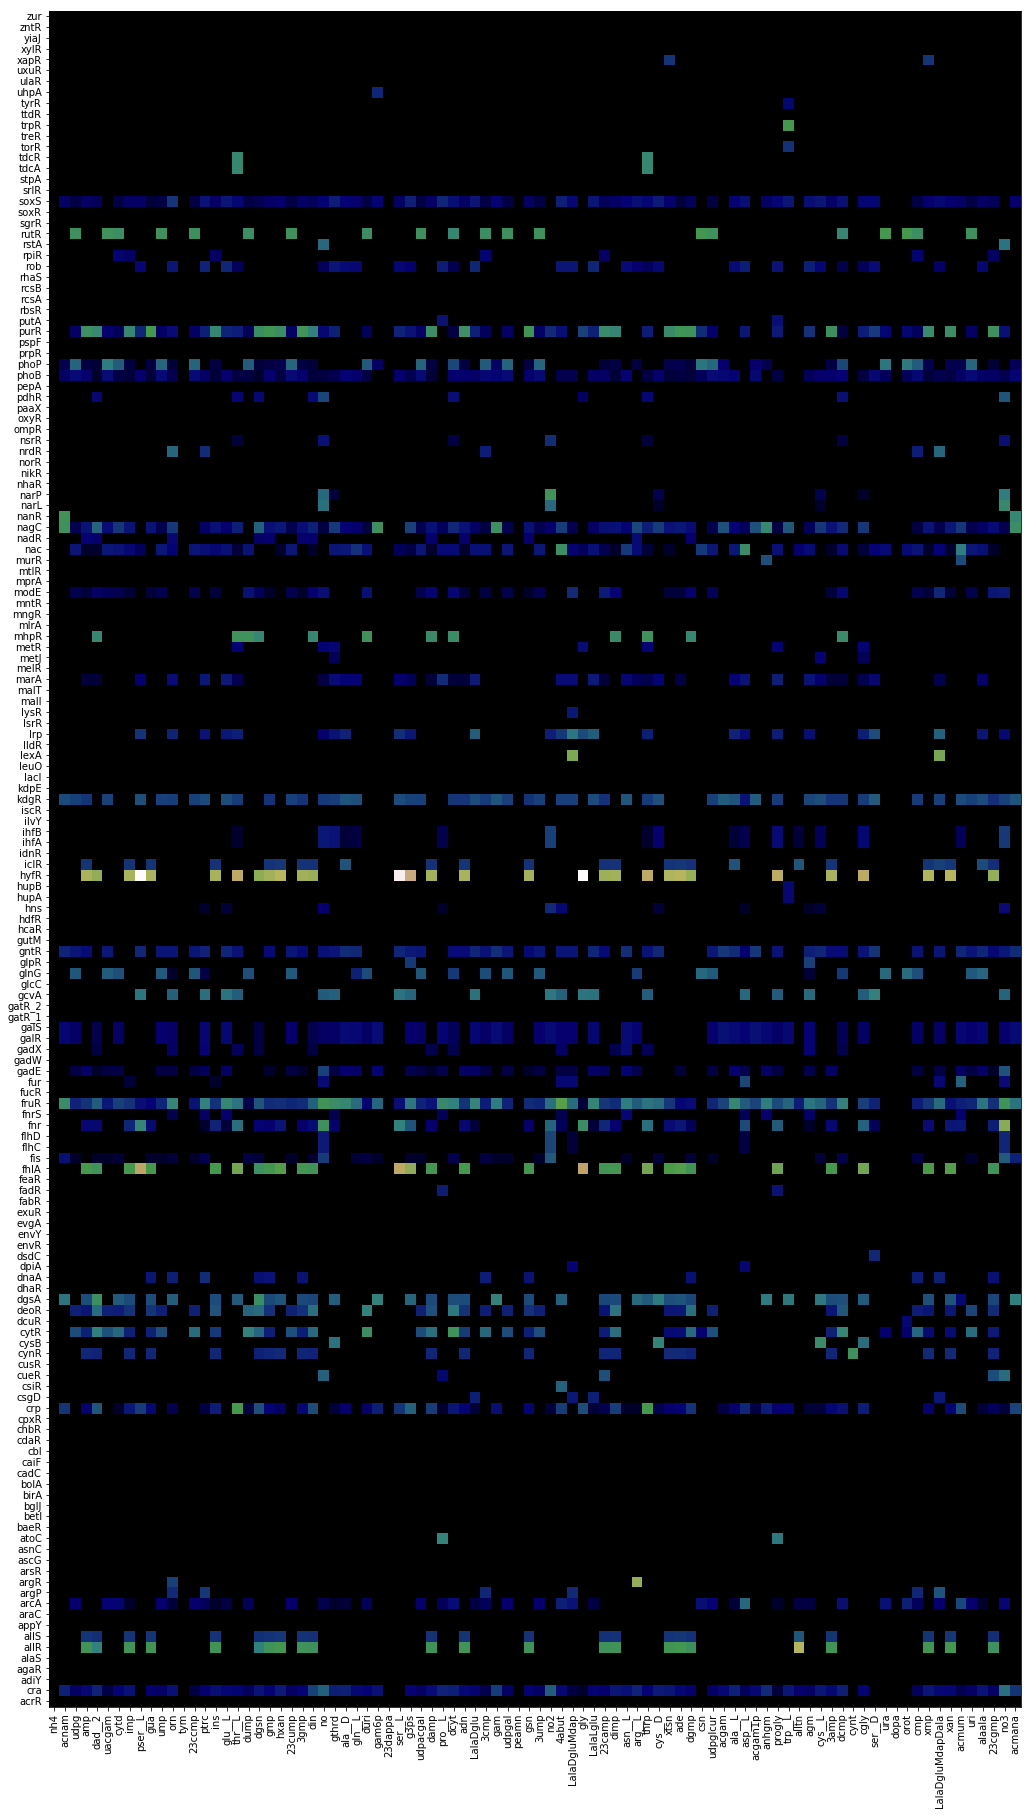

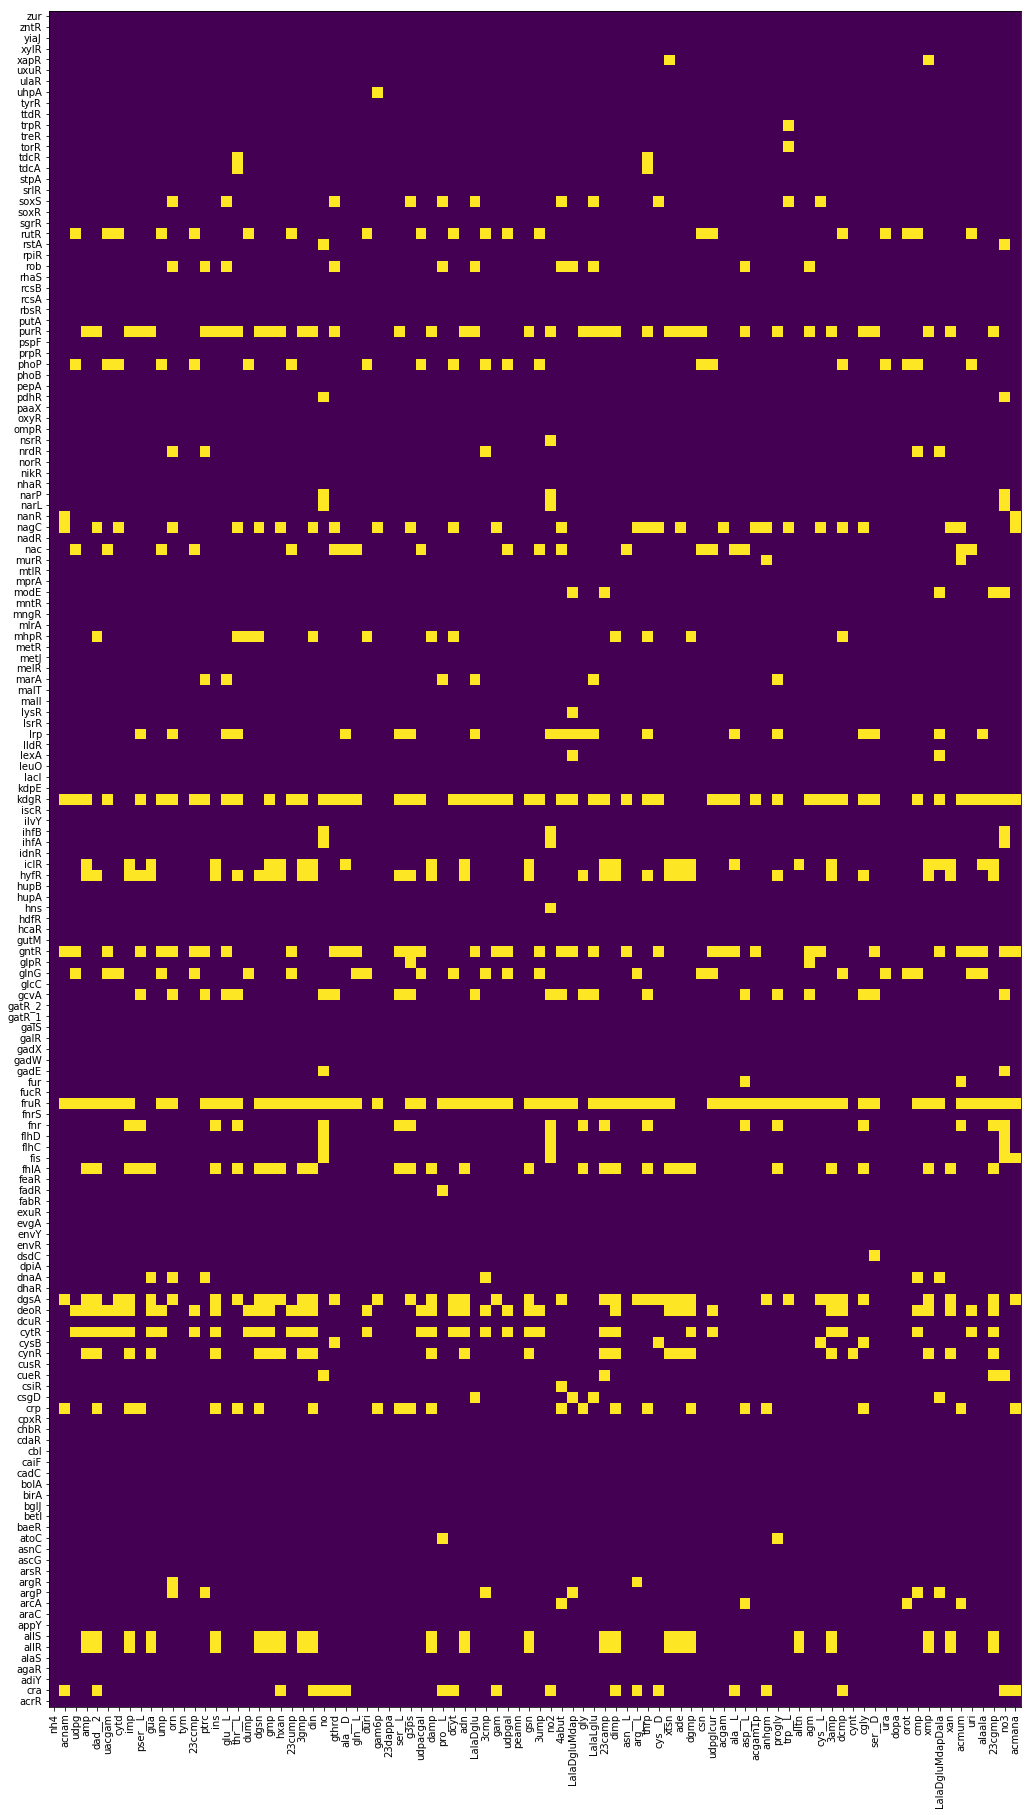

In [21]:
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline

#x = active_tfs_significance.dropna( how = "all" ).dropna( how = "all", axis = 1 ).fillna( 1 )
x = active_tfs_significance.dropna( how = "all" )
x = x.dropna( how = "all" ).fillna( 1 )
x = log( x )
figure( figsize = ( len( x.columns ) / 2., len( x.index ) / 5. ) )
pcolor( x.abs(),cmap='gist_earth' )
ylim( ymax = len( x.index ) )
xlim( xmax = len( x.columns ) )
yticks( arange( 0.5, len( x.index ), 1 ), x.index );
xticks( arange( 0.5, len( x.columns ), 1 ), x.columns, rotation = 90 );

gcf().subplots_adjust( left = 0.6 )
plt.savefig( simulation_directory + "prediction.pdf" ) 
plt.savefig( simulation_directory + "prediction.svg" ) 
plt.show()

p_thresh = log( 0.05 )
x[ x > p_thresh ] = 0
x[ x <= p_thresh ] = -10
figure( figsize = ( len( x.columns ) / 2., len( x.index ) / 5. ) )
pcolor( x.abs() )
ylim( ymax = len( x.index ) )
xlim( xmax = len( x.columns ) )
yticks( arange( 0.5, len( x.index ), 1 ), x.index );
xticks( arange( 0.5, len( x.columns ), 1 ), x.columns, rotation = 90 );

gcf().subplots_adjust( left = 0.6 )
#plt.savefig( simulation_directory + "prediction_binary.pdf" ) 
#plt.savefig( simulation_directory + "prediction_binary.svg" ) 
plt.show()

In [22]:
active_tfs_significance.to_csv("All_final_prediction_pval.csv", mode ="w", sep= ',')
x.to_csv("final_prediction.csv", mode ="w", sep= ',')

In [33]:
active_tfs_significance.gln__L.nac

0.0053183876745395795

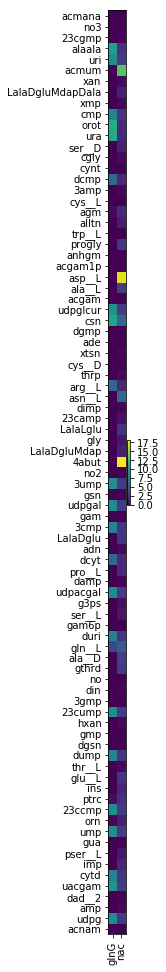

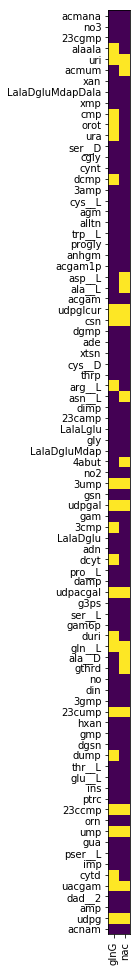

In [13]:
# only NtrC and Nac

x = active_tfs_significance.dropna( how = "all" ).dropna( how = "all", axis = 1 ).fillna( 1 )
x_ntrc = pandas.DataFrame( x.T[ "glnG" ].T )
x_nac = pandas.DataFrame( x.T[ "nac" ].T )
x0 = x_ntrc.copy()
x0 = x0.merge( x_nac, left_index = True, right_index = True )
x = x0

x = log( x )
figure( figsize = ( len( x.columns ) / 2., len( x.index ) / 5. ) )
pcolor( x.abs())
plt.colorbar()
ylim( ymax = len( x.index ) )
xlim( xmax = len( x.columns ) )
yticks( arange( 0.5, len( x.index ), 1 ), x.index );
xticks( arange( 0.5, len( x.columns ), 1 ), x.columns, rotation = 90 );

gcf().subplots_adjust( left = 0.6 )
plt.savefig( simulation_directory + "prediction_ntrc.nac.pdf" ) 
plt.savefig( simulation_directory + "prediction_ntrc.nac.svg" ) 
plt.show()

p_thresh = log( 0.05 )
x[ x > p_thresh ] = 0
x[ x <= p_thresh ] = -10
figure( figsize = ( len( x.columns ) / 2., len( x.index ) / 5. ) )
pcolor( x.abs() )
ylim( ymax = len( x.index ) )
xlim( xmax = len( x.columns ) )
yticks( arange( 0.5, len( x.index ), 1 ), x.index );
xticks( arange( 0.5, len( x.columns ), 1 ), x.columns, rotation = 90 );

gcf().subplots_adjust( left = 0.6 )
plt.savefig( simulation_directory + "prediction_ntrc.nac_binary.pdf" ) 
plt.savefig( simulation_directory + "prediction_ntrc.nac_binary.svg" ) 
plt.show()
